# Signal Chain Playbook
This notebook demonstrates the functionality within `chapp.sigchain` toolbox.

In [12]:
from chapp.sigchain import (
    mk_jpa_smat,
    mk_iso,
    mk_composite_circ,
    mk_circ_jpa,
    mk_circ,
    mk_transline_smat,
    smat2tmat_2x2,
    tmat2smat_2x2,
    smat2tmat_4x4,
    tmat2smat_4x4,
    swap_basis,
    to_idler_compat_simple,
    smat2gensmat,
    calc_noise_psd_1,
    mk_chain_smat_1,
    mk_chain_smat_2_w_mirror,
    calc_power_gains
)

from chapp.preprocessors.pp1 import PreprocessResult
from groundcontrol.util import db2lin_pow, lin2db_pow

import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as cnst
from xrscipy.signal import savgol_filter
from pathlib import Path

## JPA + Circulator
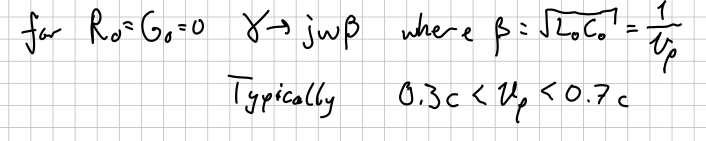

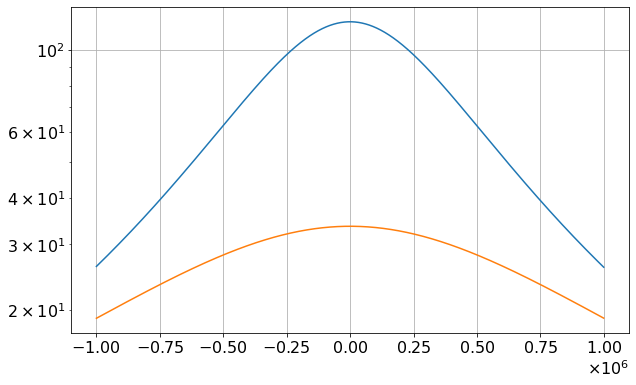

In [4]:
tcf = 0.98 # value from 
rc = 0.098
tcb = -0.089 # phase wrt rc is important

eps = 0.84
delta = 0
gamma = 7e6
beta = 1/(0.6*cnst.c)

#s22:0.098
#s31:-0.089
#s21:0.991177

fsc = 5.9e9
length = 0.010 # meters

thetaj = beta*2*np.pi*fsc*length

dnu = np.arange(-1e6, 1e6, 1e3)
ccirc = mk_composite_circ(rc, tcb, tcf)
#ccirc = mk_circ(rc, tcb, tcf)

mirror = np.broadcast_to(np.eye(2), (len(dnu), 2, 2))
jpa = mk_jpa_smat(dnu, delta, eps, gamma)

smat = mk_circ_jpa(ccirc, jpa, thetaj)
#smat = mk_circ_jpa(ccirc, mirror, beta, fsc, length)

fig, ax = plt.subplots()
ax.semilogy(dnu, np.abs(smat[..., 1, 0])**2)
ax.semilogy(dnu, np.abs(jpa[..., 0, 0])**2)
#plt.plot(dnu, np.unwrap(np.angle(jpa[..., 0, 0], deg=True)))
#plt.plot(dnu, np.unwrap(np.angle(smat[..., 1, 0], deg=True)))
plt.grid()

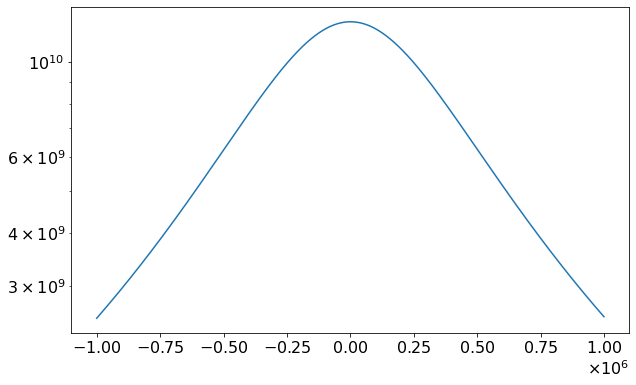

In [5]:
tcf = 0.98 # value from 
rc = 0.098
tcb = -0.089 # phase wrt rc is important

eps = 0.87
delta = 0
gamma = 7e6
beta = 1/(0.6*cnst.c)
fsc = 5.9e9
l0 = 0.02 # meters
gA = 0.95e4
rA = 0.1 # amplifier reflection

l1 = 0.03
l2 = 0.06

tlgamma = 1j*beta*2*np.pi*fsc

thetaj = beta*2*np.pi*fsc*l0

dnu = np.arange(-1e6, 1e6, 1e3)

s_tl1 = mk_transline_smat(tlgamma, l1)
s_tl2 = mk_transline_smat(tlgamma, l2)
s_ccc = mk_composite_circ(rc, tcb, tcf)
s_i = mk_iso(rc, tcb, tcf)
s_jpa = mk_jpa_smat(dnu, delta, eps, gamma)
s_cj = mk_circ_jpa(s_ccc, s_jpa, thetaj)
s_A = np.array([[rA, 0],[gA, 0]])

t2s = tmat2smat_2x2
s2t = smat2tmat_2x2
t2s_ = tmat2smat_4x4
s2t_ = smat2tmat_4x4
tics_ = to_idler_compat_simple
sb_ = swap_basis

t2_2x2 = np.einsum("...ij,...jk,...kl->...il", s2t(s_i), s2t(s_tl2), s2t(s_A))
t2_4x4 = s2t_(sb_(tics_(t2s(t2_2x2))))

t1 = s2t_(sb_(tics_(s_tl1))) @ s2t_(sb_(s_cj))
t2 = np.broadcast_to(t2_4x4, t1.shape)

stot = sb_(t2s_(t1 @ t2))

fig, ax = plt.subplots()
ax.semilogy(dnu, np.abs(stot[..., 1, 0])**2)

# Noise Model

Text(0.5, 1.0, '$\\theta_0$ = 1.40 $\\pi$ | $\\theta_1$ = 1.97 $\\pi$')

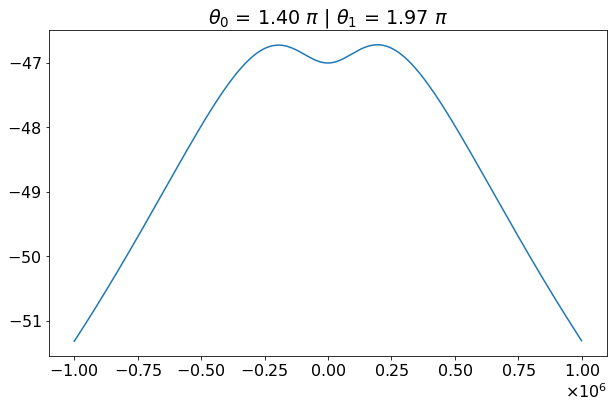

In [6]:
dnu = np.arange(-1e6, 1e6, 1e3)
tcf = 0.98 # value from 
rc = 0.098
tcb = -0.089 # phase wrt rc is important

# JPA Params
fsc = 5.9e9  # fp/2
eps = 0.93
det = 0
jdamp = 9.5e6

# Cavity Params
q0 = 40e3
dfc = 0e3
bwc = fsc/q0
beta = 2

# Output chain
gA = 0.49e7
rA = 0.1 # amplifier reflection
tnoff = 1.6
gnoff = gA**2
shemt = gnoff*tnoff*cnst.Boltzmann
tcav = 0.04

# Guesses for phases
tlbeta = 1/(0.6*cnst.c)
l0 = 0.02 # cable length connecting circ and jpa
l1 = 0.03
l2 = 0.06
theta0 = tlbeta*2*np.pi*fsc*l0
theta1 = tlbeta*2*np.pi*fsc*l1
theta2 = tlbeta*2*np.pi*fsc*l2

#theta0 = 1*np.pi
theta0 *= 1.07
theta1 *= 1

smat = mk_chain_smat_1(dnu, rc, tcb, tcf, theta0, theta1, theta2, rA, gA, det, eps, jdamp);

npsd = calc_noise_psd_1(dnu, smat, dfc, bwc, beta, fsc, tcav, shemt)
fig, ax = plt.subplots()

ax.plot(dnu, lin2db_pow(npsd*1e3))
ax.set_title(f"$\\theta_0$ = {theta0/np.pi:.2f} $\\pi$ | $\\theta_1$ = {theta1/np.pi:.2f} $\\pi$")

We can see that it reproduces the majority of effects we see in our dataset.  Let's try it on a test dataset.

# Preparing Test Dataset

In [13]:
pr = PreprocessResult.from_path(Path('~/Work/CAPP8TB6G/testset.nc').expanduser())

In [14]:
ds1 = pr.pqa_mu.isel(grunstep=10)
ds1d = pr.delta.isel(grunstep=10)
navg1 = pr.navg.isel(grunstep=10)
testds = (ds1*(1 + ds1d/np.sqrt(navg1)))
testds.plot()
ds1.sel().plot()
plt.title("");

In [25]:
pr.cavds.isel(grunstep=10)

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    fsc         float64 ...
    run         <U8 'CD10-R12'
    runstep     int64 ...
Data variables:
    dfc         float64 ...
    dfc_err     float64 ...
    bw          float64 ...
    bw_err      float64 ...
    fcav        float64 ...
    q_l         float64 ...
    q_l_err     float64 ...
    beta        float64 ...
    beta_err    float64 ...
    formfactor  float64 ...

The data has a little slope which I expect to be due to the added affects of frequency dependent loss characteristic of various components at the output path.  I will remove it with trial and error manually for now.

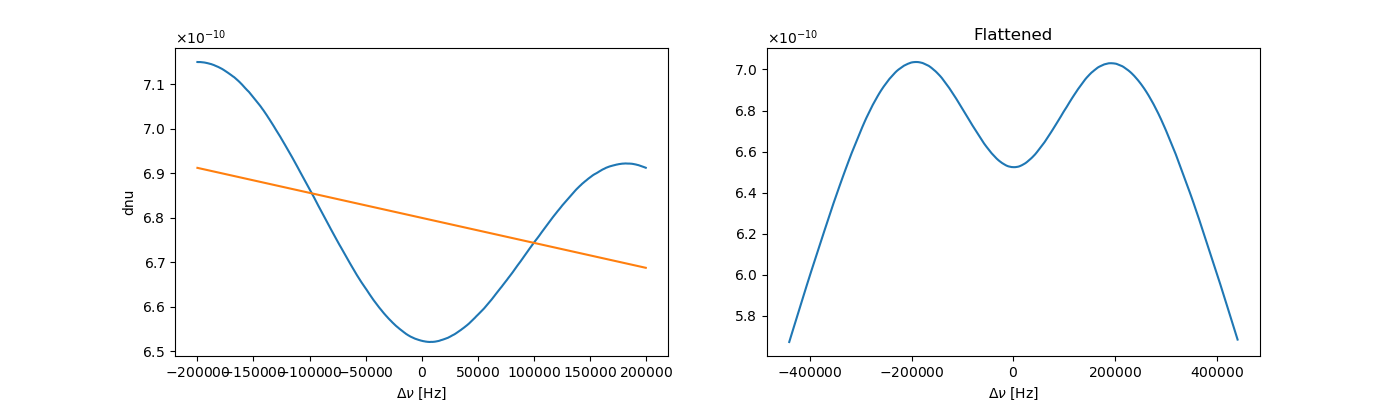

In [15]:
dslc = {'dnu': slice(-200e3, 200e3)}
alpha = 0.0165/200e3
#alpha = 0.0165/200e3
slope = (1 - alpha*ds1.dnu)
scaled_slope = 6.8e-10 * slope

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
ds1.sel(dslc).plot(ax=ax1)
(scaled_slope).sel(dslc).plot(ax=ax1)
flds = ds1/slope
flds.plot(ax=ax2)
ax1.set_title('');
ax2.set_title('Flattened');

tflds = testds/slope

# Hand Fitting

Text(0.5, 1.0, '$\\theta_0$ = 1.39 $\\pi$ | $\\theta_1$ = 1.97 $\\pi$')

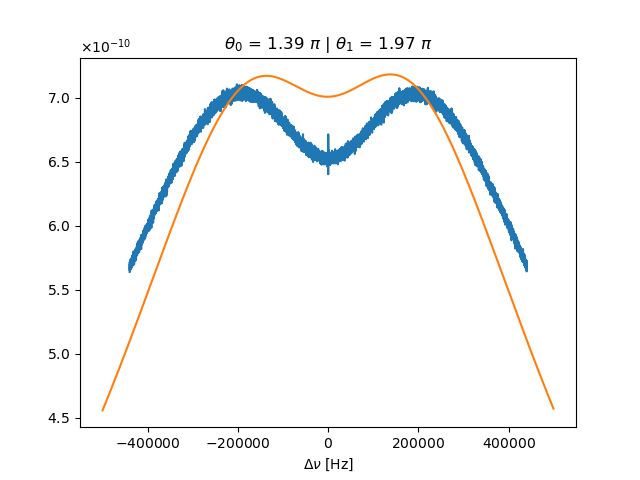

In [16]:
dnu = np.arange(-0.5e6, 0.5e6, 1e3)
tcf = 0.98 # value from 
rc = 0.098
tcb = -0.089 # phase wrt rc is important

# JPA Params
fsc = 5.9e9  # fp/2
eps = 0.86
det = 0.18
jdamp = 6.8e6

# Cavity Params
q0 = 40e3
f0 = fsc
dfc = 0e3
bwc = f0/q0
beta = 2

# Output chain
gA = 1.321e5
rA = 0.1 # amplifier reflection
tnoff = 1.6
gnoff = gA**2
shemt = gnoff*tnoff*cnst.Boltzmann
tcav = 0.04

# Guesses for phases
tlbeta = 1/(0.6*cnst.c)
l0 = 0.02 # cable length connecting circ and jpa
l1 = 0.03
l2 = 0.06
theta0 = tlbeta*2*np.pi*fsc*l0
theta1 = tlbeta*2*np.pi*fsc*l1
theta2 = tlbeta*2*np.pi*fsc*l2

#theta0 = 1*np.pi
theta0 *= 1.06
theta1 *= 1 # + 0.004j

smat = mk_chain_smat_1(dnu, rc, tcb, tcf, theta0, theta1, theta2, rA, gA, det, eps, jdamp);
npsd = calc_noise_psd_1(dnu, smat, dfc, bwc, beta, fsc, tcav, shemt)
fig, ax = plt.subplots()

tflds.plot(ax=ax)
ax.plot(dnu, npsd*62.5)
ax.set_title(f"$\\theta_0$ = {theta0/np.pi:.2f} $\\pi$ | $\\theta_1$ = {theta1/np.pi:.2f} $\\pi$")

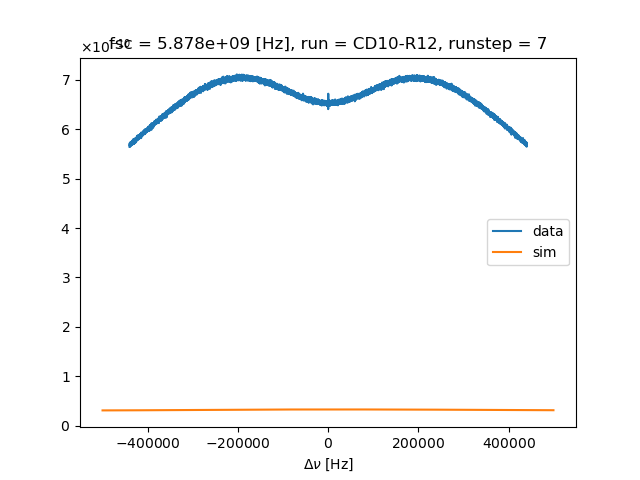

In [26]:
%matplotlib ipympl

import mpl_interactions.ipyplot as iplt
import matplotlib.pyplot as plt
import numpy as np

dnu = np.arange(-0.5e6, 0.5e6, 1e3)

tcf = 0.98  # value from
rc = 0.098
tcb = -0.089  # phase wrt rc is important

# JPA Params
#fsc = 5.9e9  # fp/2
fsc = 5.878287e9
eps = 0.86
det = 0.18
jdamp = 6.8e6

# Cavity Params
q0 = 40e3
f0 = fsc
dfc = 0e3
bwc = f0 / q0
beta = 2

# Output chain
gA = 1.321e5
rA = 0.1  # amplifier reflection

tnoff = 1.6
tcav = 0.04
nbw = 62.5

# Guesses for phases
tlbeta = 1 / (0.6 * cnst.c)
l0 = 0.02  # cable length connecting circ and jpa
l1 = 0.03
l2 = 0.06
theta0 = tlbeta * 2 * np.pi * fsc * l0
theta1 = tlbeta * 2 * np.pi * fsc * l1
theta2 = tlbeta * 2 * np.pi * fsc * l2


def noisefun(dnu, rc, tcb, tcf, theta0, theta1, gA, det, eps, jdamp, dfc, q0, beta):
    gnoff = gA ** 2
    shemt = gnoff * tnoff * cnst.Boltzmann
    bwc = fsc / q0
    smat = mk_chain_smat_1(
        dnu, rc, tcb, tcf, theta0, theta1, theta2, rA, gA, det, eps, jdamp
    )
    npsd = calc_noise_psd_1(dnu, smat, dfc, bwc, beta, fsc, tcav, shemt)
    return npsd * nbw


fig, ax = plt.subplots()
tflds.plot(ax=ax, label='data')
controls = iplt.plot(
    dnu,
    noisefun,
    rc=np.arange(0.09, 0.131, 0.001),
    tcb=np.arange(-0.08, -0.121, -0.001),
    tcf=np.arange(0.9, 0.981, 0.01),
    theta0=(theta0, theta0 + np.pi/4, 360),
    theta1=(theta1, theta1 + np.pi, 360),
    gA=(1.3e5, 1.6e5, 1000),
    det=(-0.1, 0.1, 101),
    eps=(0.6, 1.1, 5000),
    jdamp=(5e6, 10e6, 1000),
    dfc=(-500e3, 500e3, 1000),
    q0=(40000, 200000, 100),
    beta=(1.5, 2.5, 100), label='sim',ylim='auto')

_ = plt.legend()
plt.show()

Best fit so far with following parameters (fsc=5.9e9):

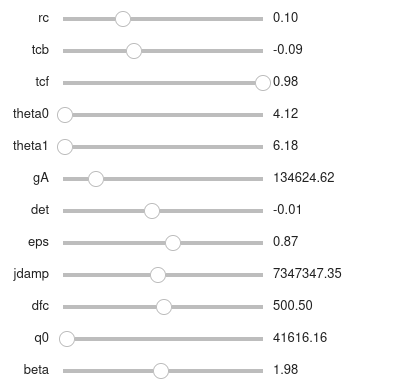


Another good fit (fsc=5.878287e9):

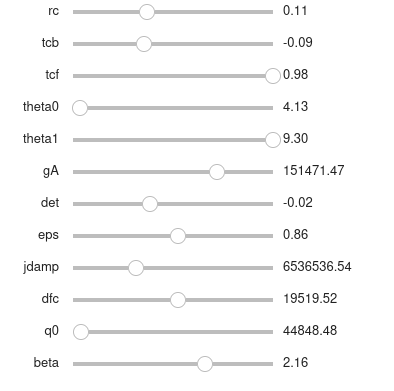

In [18]:
np.arange(-0.08, -0.121, -0.001)

array([-0.08 , -0.081, -0.082, -0.083, -0.084, -0.085, -0.086, -0.087,
       -0.088, -0.089, -0.09 , -0.091, -0.092, -0.093, -0.094, -0.095,
       -0.096, -0.097, -0.098, -0.099, -0.1  , -0.101, -0.102, -0.103,
       -0.104, -0.105, -0.106, -0.107, -0.108, -0.109, -0.11 , -0.111,
       -0.112, -0.113, -0.114, -0.115, -0.116, -0.117, -0.118, -0.119,
       -0.12 ])

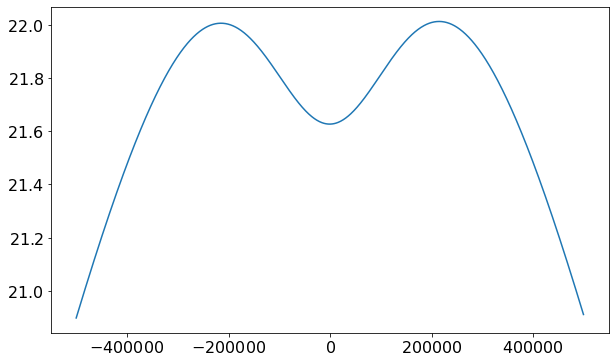

In [11]:
dnu = np.arange(-0.5e6, 0.5e6, 1e3)
tcf = 0.98 # value from 
rc = 0.098
tcb = -0.089 # phase wrt rc is important

# JPA Params
fsc = 5.9e9  # fp/2
eps = 0.85
det = 0
jdamp = 6e6

# Cavity Params
q0 = 40e3
f0 = fsc
dfc = 0
bwc = f0/q0
beta = 2

# Output chain
gA = 1
rA = 0 # amplifier reflection

# Guesses for phases
tlbeta = 1/(0.6*cnst.c)
l0 = 0.02 # cable length connecting circ and jpa
l1 = 0.03
l2 = 0.06
theta0 = tlbeta*2*np.pi*fsc*l0
theta1 = tlbeta*2*np.pi*fsc*l1
theta2 = tlbeta*2*np.pi*fsc*l2

#theta0 = 1*np.pi
theta0 *= 1
theta1 *= 1 # + 0.004j

smat, smirr = mk_chain_smat_2_w_mirror(dnu, rc, tcb, tcf, theta0, theta1, rA, gA, det, eps, jdamp);

g1, g2 = calc_power_gains(dnu, smat, dfc, bwc, beta)
#Gnoise = np.abs(g1)**2 + np.abs(g2)**2
g1m, g2m = calc_power_gains(dnu, smirr, dfc, bwc, beta)
#Gnoise_m = np.abs(g1m)**2 + np.abs(g2m)**2
#plt.plot(dnu, lin2db_pow(Gnoise/Gnoise[len(dnu)//2]))
plt.plot(dnu, lin2db_pow(g1+g2))

In [256]:
theta0,theta1

(4.451574826625373, 6.182742814757462)

This is the best I could make by manual trial and error.